In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, accuracy_score

Read the data

In [ ]:
df = pd.read_csv('data_preprocessed_2.csv')
df

,Log_PelvicIncidence,PelvicTilt,Log_LumbarLordosis,Log_SacralSlope,PelvicRadius,GS_Binned,Class_AB
0,0.545604,0.519829,0.466693,0.494805,0.307452,2,True
1,0.247374,0.296713,0.258103,0.343566,0.476718,1,True
2,0.600746,0.513934,0.574268,0.559140,0.386171,2,True
3,0.605012,0.557342,0.518009,0.539415,0.341865,2,True
4,0.397289,0.289389,0.314054,0.490055,0.409614,2,True
...,...,...,...,...,...,...,...
305,0.374176,0.360307,0.423070,0.419370,0.509410,2,False
306,0.448238,0.487138,0.328222,0.404999,0.476288,2,False
307,0.529716,0.522329,0.536861,0.474920,0.597806,2,False
308,0.338745,0.272240,0.488890,0.448468,0.521239,1,False


Change the label to numeric and use PCAn with 2 component to the original data comparison

In [ ]:
# Convert label to numerical values (for reference, though unsupervised clustering does not use labels)
df['Class_AB'] = df['Class_AB'].astype('category').cat.codes
print(df['Class_AB'])

# Drop the label column for clustering as it's an unsupervised method
X = df.drop(columns=["Class_AB"])

# Apply PCA to reduce dimensionality to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

0      1
1      1
2      1
3      1
4      1
      ..
305    0
306    0
307    0
308    0
309    0
Name: Class_AB, Length: 310, dtype: int8


Finding the optimal number of clusters number using the Elbow Method

In [6]:
# Finding the optimal number of clusters using the Elbow Method
wcss = []  # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

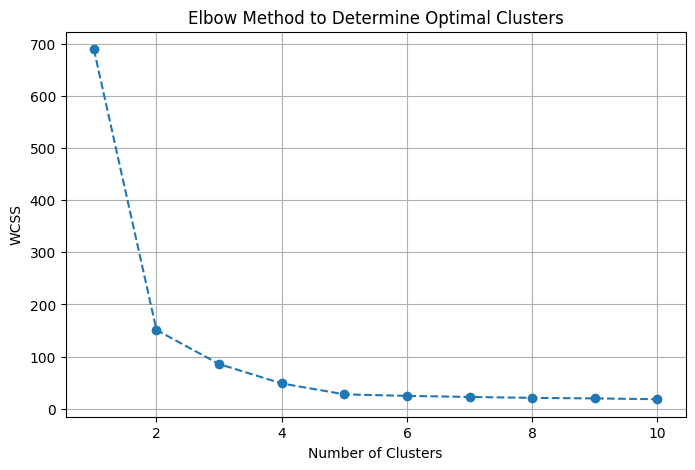

In [7]:
# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method to Determine Optimal Clusters")
plt.grid(True)
plt.show()

Calculate sillhouette score and Davies Bouldin score for KMeans, GMM, Agglomerative clustering with Original and Scaled data

In [13]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd

# Dictionaries to store results
cluster_results = {}
silhouette_scores = {}
davies_bouldin_scores = {}

# KMeans
for data, suffix in zip([X, X_pca], ["Original", "PCA"]):
    kmeans = KMeans(n_clusters=2, random_state=43) 
    clusters = kmeans.fit_predict(data)
    sil_score = silhouette_score(data, clusters)
    dbi_score = davies_bouldin_score(data, clusters)
    
    column_name = f"KMeans_{suffix}"
    cluster_results[column_name] = clusters
    silhouette_scores[column_name] = sil_score
    davies_bouldin_scores[column_name] = dbi_score

# Gaussian Mixture Model (GMM)
for data, suffix in zip([X, X_pca], ["Original", "PCA"]):
    gmm = GaussianMixture(n_components=3, random_state=43)  # Default 3 components
    clusters = gmm.fit_predict(data)
    sil_score = silhouette_score(data, clusters)
    dbi_score = davies_bouldin_score(data, clusters)
    
    column_name = f"GMM_{suffix}"
    cluster_results[column_name] = clusters
    silhouette_scores[column_name] = sil_score
    davies_bouldin_scores[column_name] = dbi_score


# Agglomerative Clustering
for data, suffix in zip([X, X_pca], ["Original", "PCA"]):
    agglom = AgglomerativeClustering(n_clusters=2) 
    clusters = agglom.fit_predict(data)
    sil_score = silhouette_score(data, clusters)
    dbi_score = davies_bouldin_score(data, clusters)
    
    column_name = f"Agglomerative_{suffix}"
    cluster_results[column_name] = clusters
    silhouette_scores[column_name] = sil_score
    davies_bouldin_scores[column_name] = dbi_score

# Convert results into DataFrame
clusters_df = pd.DataFrame(cluster_results)
silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=["Cluster_Method", "Silhouette_Score"])
davies_bouldin_df = pd.DataFrame(list(davies_bouldin_scores.items()), columns=["Cluster_Method", "Davies_Bouldin_Score"])

# Merge Silhouette and Davies-Bouldin scores
silhouette_df = silhouette_df.merge(davies_bouldin_df, on="Cluster_Method")
silhouette_df = silhouette_df.sort_values(by="Silhouette_Score", ascending=False)

# Save to CSV
silhouette_df.to_csv("silhouette_davies_bouldin_scores_normal.csv", index=False)

# Display sorted results
display(silhouette_df)

,Cluster_Method,Silhouette_Score,Davies_Bouldin_Score
1,KMeans_PCA,0.679078,0.461438
5,Agglomerative_PCA,0.679078,0.461438
3,GMM_PCA,0.660511,0.472318
0,KMeans_Original,0.645843,0.496957
4,Agglomerative_Original,0.645843,0.496957
2,GMM_Original,0.560936,0.501185


Using KMeans model because it is the highest Sillhouette Score for the data.
We search for the best parameter with highest sillhouete score using GridSearch.
We found the value of parameter are init:k-means++ ,  iteration: 100, and convergance tolerance : 0.0001  

In [9]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score, make_scorer
import pandas as pd

# Define parameter grid
param_grid = {
    "n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Number of clusters
    "init": ["k-means++", "random"],  # Initialization strategy
    "max_iter": [100, 300, 500],  # Max iterations
    "tol": [1e-4, 1e-3, 1e-2]  # Convergence tolerance
}

# Custom silhouette scoring function
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels) if len(set(labels)) > 1 else -1  # Avoid single-cluster cases

# Custom Davies-Bouldin scoring function (lower is better, so we negate it)
def davies_bouldin_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return -davies_bouldin_score(X, labels) if len(set(labels)) > 1 else float("inf")

# Initialize results list
results = []

# Run GridSearchCV for both Original and PCA-transformed data
for data, suffix in zip([X, X_pca], ["Original", "PCA"]):
    kmeans = KMeans(random_state=43)  # KMeans model
    
    # Perform Grid Search with both silhouette and Davies-Bouldin scoring
    grid_search = GridSearchCV(
        estimator=kmeans,
        param_grid=param_grid,
        scoring={"silhouette": make_scorer(silhouette_scorer), 
                 "davies_bouldin": make_scorer(davies_bouldin_scorer)},
        refit="silhouette",  # Optimize based on Silhouette Score
        cv=3,  # 3-fold cross-validation
        verbose=1,
        n_jobs=-1
    )

    # Fit grid search
    grid_search.fit(data)

    # Get best model and parameters
    best_params = grid_search.best_params_
    best_kmeans = grid_search.best_estimator_

    # Predict clusters using best parameters
    clusters = best_kmeans.fit_predict(data)
    
    # Compute final evaluation metrics
    sil_score = silhouette_score(data, clusters)
    dbi_score = davies_bouldin_score(data, clusters)

    # Store results
    results.append({
        "Data": suffix,
        "Best n_clusters": best_params["n_clusters"],
        "Best init": best_params["init"],
        "Best max_iter": best_params["max_iter"],
        "Best tol": best_params["tol"],
        "Silhouette Score": sil_score,
        "Davies-Bouldin Score": dbi_score
    })

# Convert results into DataFrame
results_df = pd.DataFrame(results)

# Display results table
display(results_df)


Fitting 3 folds for each of 162 candidates, totalling 486 fits


c:\Users\fazlu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Fitting 3 folds for each of 162 candidates, totalling 486 fits


c:\Users\fazlu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


,Data,Best n_clusters,Best init,Best max_iter,Best tol,Silhouette Score,Davies-Bouldin Score
0,Original,2,k-means++,100,0.0001,0.645843,0.496957
1,PCA,2,k-means++,100,0.0001,0.679078,0.461438


Use the best parameter from the previous result for the KMeans Clustering

In [10]:
kmeans = KMeans(n_clusters=2, init='k-means++',max_iter=100, tol=0.0001, random_state=43) 
clusters = kmeans.fit_predict(data)

Calculate the accuracy of KMean, GMM, and Agglomerative using the true label value from the data.
Presented the Accuracy, F1 Score, Recall, and Precision

In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Use GS_Binned as the ground truth labels
y_true = df["Class_AB"]

# Fit models and get cluster labels for both Normal and PCA-transformed data
clusters = {
    "KMeans_Normal": kmeans.fit_predict(X),
    "KMeans_PCA": kmeans.fit_predict(X_pca),
    "GMM_Normal": gmm.fit_predict(X),
    "GMM_PCA": gmm.fit_predict(X_pca),
    "Agglomerative_Normal": agglom.fit_predict(X),
    "Agglomerative_PCA": agglom.fit_predict(X_pca),
}

# Compute classification metrics for each method
metrics_results = []
for method, y_pred in clusters.items():
    if len(set(y_pred)) > 1:  # Avoid computing metrics for invalid clustering
        accuracy = round(accuracy_score(y_true, y_pred), 3)
        f1 = round(f1_score(y_true, y_pred, average="weighted"), 3)
        recall = round(recall_score(y_true, y_pred, average="weighted"), 3)
        precision = round(precision_score(y_true, y_pred, average="weighted"), 3)
    else:
        accuracy, f1, recall, precision = None, None, None, None  # Invalid case

    metrics_results.append([method, accuracy, f1, recall, precision])

# Create results table with rounded values
metrics_table = pd.DataFrame(metrics_results, columns=["Method", "Accuracy", "F1 Score", "Recall", "Precision"])

# Display results
metrics_table



c:\Users\fazlu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fazlu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Method,Accuracy,F1 Score,Recall,Precision
0,KMeans_Normal,0.784,0.791,0.784,0.847
1,KMeans_PCA,0.784,0.791,0.784,0.847
2,GMM_Normal,0.610,0.712,0.610,0.859
3,GMM_PCA,0.526,0.658,0.526,0.880
4,Agglomerative_Normal,0.216,0.242,0.216,0.279
5,Agglomerative_PCA,0.216,0.242,0.216,0.279


Visualize the result with scatterplot both for the true data and KMean clustering

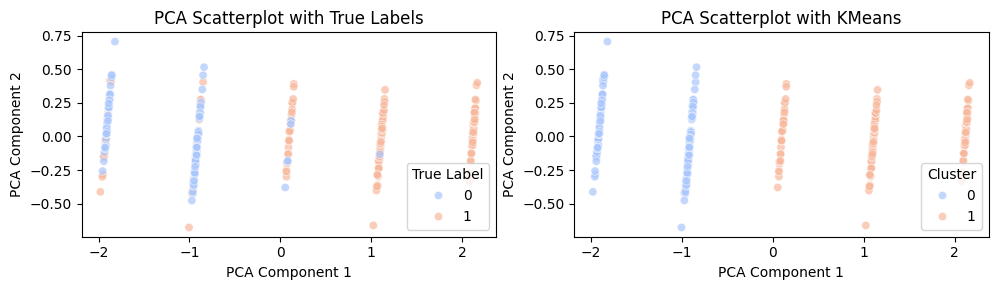

In [ ]:
knn_clusters=kmeans.fit_predict(X_pca)

# Create a figure with 3 subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Plot PCA results with True Labels
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Class_AB'], palette="coolwarm", alpha=0.7, ax=axes[0])
axes[0].set_title("PCA Scatterplot with True Labels")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(title="True Label")

# Plot PCA results with KMeans Clustering labels
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=knn_clusters, palette="coolwarm", alpha=0.7, ax=axes[1])
axes[1].set_title("PCA Scatterplot with KMeans")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")
axes[1].legend(title="Cluster")


# Adjust layout for better spacing
plt.tight_layout()
plt.show()